## Imports and setup

In [1]:
from utilities import *
import numpy as np
import cv2
import os
import re
import importlib
import pandas as pd
import sklearn
from sklearn import preprocessing
from functools import reduce
from matplotlib import cm
import matplotlib as mpl
import matplotlib.animation as animation
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

%matplotlib widget

plt.rcParams.update({
    'grid.linewidth':  0,
    'grid.color':  'lightgrey',
    'savefig.facecolor': (0.0, 0.0, 0.0, 0.0), 
    'savefig.transparent': True,
})



## Basic functions

In [2]:
def scanDir(directory, extension='avi', filter_string=None, filter_out=False, verbose=False):
    file_list=[]
    for root, dirs, files in os.walk(directory):
        for name in files:
            if name.lower().endswith(extension):
                filename = os.path.join(root, name)
                if verbose == True:
                    print("Found file with extension ."+ extension + ": " + filename)
                file_list.append(filename)
                continue
            else:
                continue
    if filter_string != None:
        if filter_out:
            file_list = [file for file in file_list if not re.search(filter_string, file)]
        else:
            file_list = [file for file in file_list if re.search(filter_string, file)]
    return(file_list)

def convertRStoLS(df):
    newdf = df.copy()
    colnames = newdf.columns
    cols_to_flip = [col for col in colnames if 'ABAD' in col or 'LAR' in col]
    for col in cols_to_flip:
        newdf[col] = newdf[col]*-1
    return(newdf)

def convertMMtoCM(df):
    newdf = df.copy()
    colnames = newdf.columns
    data_cols = [col for col in colnames if not 'frame' in col]
    for col in data_cols:
        newdf[col] = newdf[col]*10
    return(newdf)
        
def format3dPlot(axObj, title, xRange, yRange, zRange, view=None, color='grey', minimal=False):
    axObj.set_title(title)
    if view:
        axObj.view_init(view[0], view[1])
    if minimal:
        axObj.set_axis_off()
    axObj.set_xlabel('- add   X   + abd', size='small', color=colors['red'])
    axObj.set_ylabel('- sup   Y   + prn', size='small', color=colors['green'])
    axObj.set_zlabel('- ext   Z   + flx', size='small', color=colors['blue'])
    axObj.set_xlim(xRange[0], xRange[1])
    axObj.set_ylim(yRange[0], yRange[1])
    axObj.set_zlim(zRange[0], zRange[1])  
    axObj.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0)) 
    axObj.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0)) 
    axObj.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0)) 
    
    axObj.w_xaxis.line.set_color((1.0, 1.0, 1.0, 0.0)) 
    axObj.w_yaxis.line.set_color((1.0, 1.0, 1.0, 0.0)) 
    axObj.w_zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
    axObj.minorticks_off()
    axObj.tick_params(reset=True,colors=color, labelsize='x-small')
    return axObj


def getShoulderRotationRanges(df):
    maxRx = math.ceil(max(df['Rx'])/10)*10
    maxcRx = math.ceil(max(df['cRx'])/10)*10
    minRx = math.floor(min(df['Rx'])/10)*10
    mincRx = math.floor(min(df['cRx'])/10)*10
    maxRy = math.ceil(max(df['Ry'])/10)*10
    minRy = math.floor(min(df['Ry'])/10)*10
    maxRz = math.ceil(max(df['Rz'])/10)*10
    minRz = math.floor(min(df['Rz'])/10)*10
    result = {'maxRx':maxRx, 'maxcRx':maxcRx, 'minRx':minRx, 'mincRx':mincRx, 'maxRy':maxRy, 'minRy':minRy, 'maxRz':maxRz, 'minRz':minRz}
    return result

def getElbowRotationRanges(df):
    maxRx = math.ceil(max(df['eRx'])/10)*10
    maxcRx = math.ceil(max(df['ceRx'])/10)*10
    minRx = math.floor(min(df['eRx'])/10)*10
    mincRx = math.floor(min(df['ceRx'])/10)*10
    maxRy = math.ceil(max(df['eRy'])/10)*10
    minRy = math.floor(min(df['eRy'])/10)*10
    maxRz = math.ceil(max(df['eRz'])/10)*10
    minRz = math.floor(min(df['eRz'])/10)*10
    result = {'maxRx':maxRx, 'maxcRx':maxcRx, 'minRx':minRx, 'mincRx':mincRx, 'maxRy':maxRy, 'minRy':minRy, 'maxRz':maxRz, 'minRz':minRz}
    return result

def getClavscapRotationRanges(df):
    maxRx = math.ceil(max(df['clavRx'])/10)*10
    minRx = math.floor(min(df['clavRx'])/10)*10
    result = {'maxRx':maxRx, 'minRx':minRx}
    return result

def getTotalRotationRanges(df):
    shoulder = getShoulderRotationRanges(df)
    elbow = getElbowRotationRanges(df)
    clavscap = getClavscapRotationRanges(df)
    maxRx = max(shoulder['maxRx'],elbow['maxRx'],clavscap['maxRx'])
    maxcRx = max(shoulder['maxcRx'],elbow['maxcRx'])
    minRx =  min(shoulder['minRx'],elbow['minRx'],clavscap['minRx'])
    mincRx = min(shoulder['mincRx'],elbow['mincRx'])
    maxRy = max(shoulder['maxRy'],elbow['maxRy'])
    minRy = min(shoulder['minRy'],elbow['minRy'])
    maxRz = max(shoulder['maxRz'],elbow['maxRz'])
    minRz = min(shoulder['minRz'],elbow['minRz'])
    result = {'maxRx':maxRx, 'maxcRx':maxcRx, 'minRx':minRx, 'mincRx':mincRx, 'maxRy':maxRy, 'minRy':minRy, 'maxRz':maxRz, 'minRz':minRz}
    return result

def on_move(event):
    if event.inaxes == ax0:
        ax1.view_init(elev=ax0.elev, azim=ax0.azim)
    elif event.inaxes == ax1:
        ax0.view_init(elev=ax1.elev, azim=ax1.azim)
    else:
        return
    fig.canvas.draw_idle()
    
def on_move4(event):
    if event.inaxes == ax0:
        ax1.view_init(elev=ax0.elev, azim=ax0.azim)
        ax2.view_init(elev=ax0.elev, azim=ax0.azim)
        ax3.view_init(elev=ax0.elev, azim=ax0.azim)
    elif event.inaxes == ax1:
        ax0.view_init(elev=ax1.elev, azim=ax1.azim)
        ax2.view_init(elev=ax1.elev, azim=ax1.azim)
        ax3.view_init(elev=ax1.elev, azim=ax1.azim)
    elif event.inaxes == ax2:
        ax0.view_init(elev=ax2.elev, azim=ax2.azim)
        ax1.view_init(elev=ax2.elev, azim=ax2.azim)
        ax3.view_init(elev=ax2.elev, azim=ax2.azim)
    elif event.inaxes == ax3:
        ax0.view_init(elev=ax3.elev, azim=ax3.azim)
        ax1.view_init(elev=ax3.elev, azim=ax3.azim)
        ax2.view_init(elev=ax3.elev, azim=ax3.azim)
    else:
        return
    fig.canvas.draw_idle()
    
def on_move6(event):
    if event.inaxes == ax0:
        ax1.view_init(elev=ax0.elev, azim=ax0.azim)
        ax2.view_init(elev=ax0.elev, azim=ax0.azim)
        ax3.view_init(elev=ax0.elev, azim=ax0.azim)
        ax4.view_init(elev=ax0.elev, azim=ax0.azim)
        ax5.view_init(elev=ax0.elev, azim=ax0.azim)
    elif event.inaxes == ax1:
        ax0.view_init(elev=ax1.elev, azim=ax1.azim)
        ax2.view_init(elev=ax1.elev, azim=ax1.azim)
        ax3.view_init(elev=ax1.elev, azim=ax1.azim)
        ax4.view_init(elev=ax1.elev, azim=ax1.azim)
        ax5.view_init(elev=ax1.elev, azim=ax1.azim)
    elif event.inaxes == ax2:
        ax0.view_init(elev=ax2.elev, azim=ax2.azim)
        ax1.view_init(elev=ax2.elev, azim=ax2.azim)
        ax3.view_init(elev=ax2.elev, azim=ax2.azim)
        ax4.view_init(elev=ax2.elev, azim=ax2.azim)
        ax5.view_init(elev=ax2.elev, azim=ax2.azim)
    elif event.inaxes == ax3:
        ax0.view_init(elev=ax3.elev, azim=ax3.azim)
        ax1.view_init(elev=ax3.elev, azim=ax3.azim)
        ax2.view_init(elev=ax3.elev, azim=ax3.azim)
        ax4.view_init(elev=ax3.elev, azim=ax3.azim)
        ax5.view_init(elev=ax3.elev, azim=ax3.azim)
    elif event.inaxes == ax4:
        ax0.view_init(elev=ax4.elev, azim=ax4.azim)
        ax1.view_init(elev=ax4.elev, azim=ax4.azim)
        ax2.view_init(elev=ax4.elev, azim=ax4.azim)
        ax3.view_init(elev=ax4.elev, azim=ax4.azim)
        ax5.view_init(elev=ax4.elev, azim=ax4.azim)
    elif event.inaxes == ax5:
        ax0.view_init(elev=ax5.elev, azim=ax5.azim)
        ax1.view_init(elev=ax5.elev, azim=ax5.azim)
        ax2.view_init(elev=ax5.elev, azim=ax5.azim)
        ax3.view_init(elev=ax5.elev, azim=ax5.azim)
        ax4.view_init(elev=ax5.elev, azim=ax5.azim)
    else:
        return
    fig.canvas.draw_idle()
    
def addCosGrid(gridAx, xRange, yRange, zRange, interval, zLevels=1, alpha=0, **kwargs):  
    xMin = math.floor(xRange[0])
    xMax = math.ceil(xRange[1])+1
    yMin = math.floor(yRange[0])
    yMax = math.ceil(yRange[1])+1
    zMin = math.floor(zRange[0])
    zMax = math.ceil(zRange[1])+1
    xs= np.arange(xMin, xMax+1, 1)
    ys= np.arange(yMin, yMax, 1)
    xSize = abs(xMin)+abs(xMax)
    ySize = abs(yMin)+abs(yMax)
    zSize = abs(zMin)+abs(zMax)
    alphas = np.ones(xSize)*alpha
    xx, yy = np.meshgrid(xs, ys)
    cxx = xx*np.cos(np.radians(yy))
    zMaxMinMax = max((abs(zMin),abs(zMax)))
    if zLevels <2:
        zs = np.zeros(zSize)
    else:
        zs = np.linspace(zMaxMinMax*-1, zMaxMinMax, zLevels)
    for zLevel in list(range(zLevels)):
        zz = np.ones((cxx.shape[0],cxx.shape[1]))*zs[zLevel]
        gridAx.plot_wireframe(cxx, yy, zz, rcount = xSize/interval, ccount=ySize/interval, **kwargs)

def animate(i):
    ax0.view_init(elev=45, azim=i/10)
    ax1.view_init(elev=45, azim=i/10)
    return fig

## Ingest data

In [488]:
# input_dir=r"/Volumes/spierce_lab/lab/NSF forelimb project/Sophie echidna project/Filtered XROMM trials"

# all_mots = scanDir(input_dir,"mot")
# all_mots = [path for path in all_mots if "XROMM" not in os.path.basename(path)]

# mot_dict = [{'id':os.path.splitext(os.path.basename(mot))[0],'path':os.path.dirname(mot),'mot_df':pd.read_csv(mot,sep='\t',header=6)} for mot in all_mots]

# frame_ranges = {'44L':
#                  {'9':(35,799),
#                   '13':(2,799),
#                   '14':(2,799),
#                  },
#                  '46L':
#                  {'15':(2,800),
#                   '16':(2,800),
#                   '17':(2,800),
#                   '18':(2,800),         
#                  },
#                  '46R':
#                  {'2':(2,800),
#                   '3':(2,800),
#                   '4':(2,800),
#                   '9':(2,800),         
#                  },
#                  '48L':
#                  {'4':(74,800),
#                   '5':(74,800),
#                   '6':(77,800),
#                   '7':(51,800),   
#                   '8':(59,800),  
#                  },
#                  '48R':
#                  {'15':(67,800),
#                   '16':(79,800),
#                   '17':(83,800),
#                   '18':(87,800),   
#                   '19':(67,800),  
#                  },
#                 }

# for trial in mot_dict:
#     animal = trial['id'].rsplit('_',1)[0].replace('_','').replace('HS','')
#     trial['animal'] = animal
#     run = trial['id'].rsplit('_',1)[-1].replace('tr','').replace('run','').replace('Run','')
#     trial['run'] = run
#     all_MMAs = scanDir(trial['path'] ,"csv")
# #     maya_MMAs = [path for path in all_MMAs if not any (exclusions in os.path.basename(path) for exclusions in ["plt","SIMM"])]
#     maya_MMAs = [path for path in all_MMAs if "redo" in os.path.basename(path)]
#     simm_MMAs = [path for path in all_MMAs if "plt" in os.path.basename(path)]
#     maya_shoulder = [path for path in maya_MMAs if "houlder" in path]
#     simm_shoulder = [path for path in simm_MMAs if "houlder" in path and "MMA" in path]
#     maya_elbow = [path for path in maya_MMAs if "lbow" in path]
#     simm_elbow = [path for path in simm_MMAs if "lbow" in path and "MMA" in path]
#     maya_clav = [path for path in maya_MMAs if "lav" in path and "houlder" not in path]
#     simm_clav = [path for path in simm_MMAs if "lav" in path and "MMA" in path]
# #     if len(maya_shoulder) != len(simm_shoulder):
# #         print("shoulder "+trial['id'])
# #         print(maya_shoulder)
# #         print(simm_shoulder)
# #     if len(maya_elbow) != len(simm_elbow):
# #         print("elbow "+trial['id'])
# #         print(maya_elbow)
# #         print(simm_elbow)
# #     if len(maya_clav) != len(simm_clav):
# #         print("clav "+trial['id'])
# #         print(maya_clav)
# #         print(simm_clav)
#     maya_crop = frame_ranges[animal][run]

#     simm_shoulder_dfs = [pd.read_csv(simm) for simm in simm_shoulder]
#     maya_shoulder_dfs = [pd.read_csv(maya).iloc[maya_crop[0]:maya_crop[1]+1].reset_index(drop=True) for maya in maya_shoulder]

#     simm_elbow_dfs = [pd.read_csv(simm) for simm in simm_elbow]
#     maya_elbow_dfs = [pd.read_csv(maya).iloc[maya_crop[0]:maya_crop[1]+1].reset_index(drop=True) for maya in maya_elbow]

#     simm_clav_dfs = [pd.read_csv(simm) for simm in simm_clav]
#     maya_clav_dfs = [pd.read_csv(maya).iloc[maya_crop[0]:maya_crop[1]+1].reset_index(drop=True) for maya in maya_clav]
    
#     for joint in [maya_shoulder_dfs,maya_elbow_dfs,maya_clav_dfs]:
#         for maya_df in joint:
#             maya_df['frame'] = maya_df.index + 1

#     trial['simm_shoulder'] = simm_shoulder_dfs
#     trial['maya_shoulder'] = maya_shoulder_dfs
#     trial['simm_elbow'] = simm_elbow_dfs
#     trial['maya_elbow'] = maya_elbow_dfs
#     trial['simm_clav'] = simm_clav_dfs
#     trial['maya_clav'] = maya_clav_dfs

# simm_colnames = []
# maya_colnames = []
# for trial in mot_dict:
#     for joint in ['simm_shoulder','simm_elbow','simm_clav']:
#         for simm_df in trial[joint]:
#             simm_colnames.append(list(simm_df.columns))
#     for joint in ['maya_shoulder','maya_elbow','maya_clav']:
#         for maya_df in trial[joint]:
#             maya_colnames.append(list(maya_df.columns))
# simm_colnames = dict.fromkeys(sorted(list(set([item for sublist in simm_colnames for item in sublist]))))
# maya_colnames = dict.fromkeys(sorted(list(set([item for sublist in maya_colnames for item in sublist]))))

# simm_replacements = {
#     r'(?=.*frame).*':'frame',
#     r'(?=.*bic)(?=.*brev).*':'biceps_brevis',
#     r'(?=.*bic)(?=.*long).*':'biceps_longus',
#     r'(?=.*coraco)(?=.*long).*':'coracobrachialis_longus',
#     r'(?=.*delt)(?=.*clav).*':'deltoid_clav',
#     r'(?=.*lat)(?=.*pt1).*':'latissimus_1',
#     r'(?=.*lat)(?=.*pt2).*':'latissimus_vert',
#     r'(?=.*lat)(?=.*pt3).*':'latissimus_3',
#     r'(?=.*lat)(?=.*pt4).*':'latissimus_scap',
#     r'(?=.*pec)(?=.*pt1).*':'pectoralis_intermediate',
#     r'(?=.*pec)(?=.*pt2).*':'pectoralis_cran',
#     r'(?=.*pec)(?=.*pt3).*':'pectoralis_caud',
#     r'(?=.*triceps).*':'triceps_longus', 
#     r'(?=.*elbow).*':'elbow',
#     r'(?=.*shoulder).*':'shoulder',
#     r'(?=.*clavscap).*':'clavscap.ABAD',
#     r'(?=.*rotation).*':'LAR',
#     r'(?=.*uction).*':'ABAD',
#     r'(?=.*exion).*':'FLEX',   
# }

# maya_replacements = {
#     r'(?=.*frame).*':'frame',
#     r'(?=.*bicep).*':'biceps_brevis',
#     r'(?=.*cb).*':'coracobrachialis_longus',
#     r'(?=.*clavd).*':'deltoid_clav',
#     r'(?=.*lat)(?=.*scap).*':'latissimus_scap',
#     r'(?=.*lat)(?=.*vert).*':'latissimus_vert',
#     r'(?=.*pec)(?=.*o1_).*':'pectoralis_cran',
#     r'(?=.*pec)(?=.*o2_).*':'pectoralis_caud',
#     r'(?=.*pec)(?=.*pt1).*':'pectoralis_cran',
#     r'(?=.*pec)(?=.*pt2).*':'pectoralis_caud',
#     r'(?=.*triceps).*':'triceps_longus',
#     r'(?=.*elbow).*':'elbow',
#     r'(?=.*shoulder).*':'shoulder',
#     r'(?=.*_clav_).*':'clavscap',
#     r'(?=.*yma).*':'LAR',
#     r'(?=.*xma).*':'ABAD',
#     r'(?=.*zma).*':'FLEX',    
# }


# simm_colnames_new = {}
# maya_colnames_new = {}
# for colname in simm_colnames:
#     ids = []
#     for condition in simm_replacements:
#         if re.match(condition, colname, re.IGNORECASE):
#             ids.append(simm_replacements[condition])
#     simm_colnames_new[colname] = 'simm.'+'.'.join(ids) if 'frame' not in colname else '.'.join(ids)
# for colname in maya_colnames:
#     ids = []
#     for condition in maya_replacements:
#         if re.match(condition, colname, re.IGNORECASE):
#             ids.append(maya_replacements[condition])
#     maya_colnames_new[colname] = 'maya.'+'.'.join(ids) if 'frame' not in colname else '.'.join(ids)
    
# for trial in mot_dict:
#     dfs = []
#     for joint in ['shoulder','elbow','clav']:
#         for simm_df in trial['simm'+'_'+joint]:
#             simm_df.rename(simm_colnames_new, axis=1, inplace=True)
#             dfs.append(simm_df)
#         for maya_df in trial['maya'+'_'+joint]:
#             maya_df.rename(maya_colnames_new, axis=1, inplace=True)
#             maya_df = convertMMtoCM(maya_df)
#             if trial['animal'][-1] == 'R':
#                 maya_df = convertRStoLS(maya_df)
#             dfs.append(maya_df)
#     dfs.append(trial['mot_df'])
#     df = reduce(lambda df1,df2: pd.merge(df1,df2,on='frame'), dfs)
#     df['animal'] = trial['animal']
#     df['run'] = trial['run']
#     trial['df'] = df
# dfs = [trial['df'] for trial in mot_dict]
# df = reduce(lambda df1,df2: pd.merge(df1,df2,how='outer'), dfs)    
    
    
# all_data = df.copy()
# shoulder_rot_df = all_data.loc[:,['shoulder_abduction_adduction','shoulder_LA_Rotation','shoulder_flexion_extension']]
# shoulder_rot_df['radRy_LAR'] = np.radians(shoulder_rot_df['shoulder_LA_Rotation'])
# shoulder_rot_df['cosRy_LAR'] = np.cos(shoulder_rot_df['radRy_LAR'])
# shoulder_rot_df['Rx_ABADcosRy_LAR'] = shoulder_rot_df['cosRy_LAR'].multiply(shoulder_rot_df['shoulder_abduction_adduction'])
# all_data['cRx'] = shoulder_rot_df['Rx_ABADcosRy_LAR']

# elbow_rot_df = all_data.loc[:,['elbow_abduction_adduction','elbow_LA_Rotation','elbow_flexion_extension']]
# elbow_rot_df['radRy_LAR'] = np.radians(elbow_rot_df['elbow_LA_Rotation'])
# elbow_rot_df['cosRy_LAR'] = np.cos(elbow_rot_df['radRy_LAR'])
# elbow_rot_df['Rx_ABADcosRy_LAR'] = elbow_rot_df['cosRy_LAR'].multiply(elbow_rot_df['elbow_abduction_adduction'])
# all_data['ceRx'] = elbow_rot_df['Rx_ABADcosRy_LAR']

# all_data = all_data.rename({'shoulder_abduction_adduction':'Rx','shoulder_LA_Rotation':'Ry','shoulder_flexion_extension':'Rz','elbow_abduction_adduction':'eRx','elbow_LA_Rotation':'eRy','elbow_flexion_extension':'eRz','clavscap_angle':'clavRx'} ,axis=1)

# all_data.to_csv('/Users/phil/Desktop/phil2021feb_all_echidna_newaxes_alljoints.csv')
# all_data.to_csv(input_dir+'/phil2021feb_all_echidna_newaxes_alljoints.csv')
# all_data.to_csv('/Users/phil/Development/possumpolish/echidna_plots/phil2021feb_all_echidna_newaxes_alljoints.csv')







## Define plotting parameters

In [3]:
all_data = pd.read_csv('/Users/phil/Desktop/phil2021feb_all_echidna_newaxes_alljoints.csv',index_col=0)
colors = {'red':'#B74B4B', 'green':'#8EC15A', 'blue':'#5083D2'}        
viewYZ = (0,0)
viewXZ = (0,90)
viewXY = (90,90)
view3Q = (45,45)
view3Qneg = (-45,225)
view3Qst = (-45,45)
view3Qsw = (135,45)
vX, vY = viewXY


## Set up dictionary for muscle plots

In [8]:
muscles_to_compare = ['biceps_brevis','coracobrachialis_longus','deltoid_clav','latissimus_vert','latissimus_scap','pectoralis_cran','pectoralis_caud','triceps_longus']
joints = ['shoulder','elbow','clavscap']
def makeMuscleDict(muscles_to_compare, joints):
    muscle_dict = dict.fromkeys(muscles_to_compare)
    for muscle in muscles_to_compare:
        muscle_dict[muscle] = dict.fromkeys(joints)
        subset_list = [name for name in all_data.columns if muscle in name]
        for joint in joints:
            subsubset_list = [name for name in subset_list if joint in name]
            if joint == 'clavscap':
                subsubset_list = [name for name in subsubset_list if 'ABAD' in name]
            if len(subsubset_list):
                subset_df = all_data.dropna(subset=subsubset_list)
                seplist = "|".join(subsubset_list)
                muscle_dict[muscle][joint] = subset_df.iloc[:,subset_df.columns.str.contains('frame|animal|run|Rx|Ry|Rz|cRx|ceRx|eRx|eRy|eRz|clavRx|'+seplist)].copy()
            else:
                del muscle_dict[muscle][joint]
    return muscle_dict

## Plot rom, broken out by animal-side

In [495]:
def plotROMSeparate(df, joint):
    maxRx, maxcRx, minRx, mincRx, maxRy, minRy, maxRz, minRz = getTotalRotationRanges(df).values()
    plt.close('all')
    plt.rcParams['grid.linewidth'] = 0
    plt.rcParams['grid.color'] = 'lightgrey'
    fig = plt.figure(figsize=[12,12], constrained_layout=True)
    ax0 = fig.add_subplot(221, projection='3d', proj_type = 'ortho')
    ax1 = fig.add_subplot(222, projection='3d', proj_type = 'ortho')
    ax2 = fig.add_subplot(223, projection='3d', proj_type = 'ortho')
    ax3 = fig.add_subplot(224, projection='3d', proj_type = 'ortho')
    groups = all_data.groupby("animal")
    for name, group in groups:
        if joint == 'shoulder':
            xs = group.cRx
            ys = group.Ry
            zs = group.Rz
        elif joint == 'elbow':
            xs = group.ceRx
            ys = group.eRy
            zs = group.eRz
        ax0.scatter(xs,ys,zs, s=3, depthshade=False, label=name)
        ax1.scatter(xs,ys,zs, s=3, depthshade=False, label=name)
        ax2.scatter(xs,ys,zs, s=3, depthshade=False, label=name)
        ax3.scatter(xs,ys,zs, s=3, depthshade=False, label=name)

    format3dPlot(ax0, 'ROM', (mincRx, maxcRx), (minRy, maxRy), (minRz, maxRz), view=view3Q)
    addCosGrid(ax0, (minRx,maxRx), (minRy,maxRy), (minRz,maxRz), 5, zLevels=1, color='grey', linewidths=0.1)

    format3dPlot(ax1, 'ROM', (mincRx, maxcRx), (minRy, maxRy), (minRz, maxRz), view=viewYZ)
    addCosGrid(ax1, (minRx,maxRx), (minRy,maxRy), (minRz,maxRz), 5, zLevels=1, color='grey', linewidths=0.1)

    format3dPlot(ax2, 'ROM', (mincRx, maxcRx), (minRy, maxRy), (minRz, maxRz), view=viewXZ)
    addCosGrid(ax2, (minRx,maxRx), (minRy,maxRy), (minRz,maxRz), 5, zLevels=1, color='grey', linewidths=0.1)

    format3dPlot(ax3, 'ROM', (mincRx, maxcRx), (minRy, maxRy), (minRz, maxRz), view=viewXY)
    addCosGrid(ax3, (minRx,maxRx), (minRy,maxRy), (minRz,maxRz), 5, zLevels=1, color='grey', linewidths=0.1)

    fig.suptitle(joint+' ROM for all sides, color by side', fontsize=16)

    plt.legend()

plotROMSeparate(all_data,'shoulder')
plotROMSeparate(all_data,'elbow')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## Plot rom, pooled

In [ ]:
# rom, broken out by animal-side
def plotROMPooled(df, joint):
    maxRx, maxcRx, minRx, mincRx, maxRy, minRy, maxRz, minRz = getTotalRotationRanges(df).values()
    plt.close('all')
    plt.rcParams['grid.linewidth'] = 0
    plt.rcParams['grid.color'] = 'lightgrey'
    fig = plt.figure(figsize=[12,12], constrained_layout=True)
    ax0 = fig.add_subplot(221, projection='3d', proj_type = 'ortho')
    ax1 = fig.add_subplot(222, projection='3d', proj_type = 'ortho')
    ax2 = fig.add_subplot(223, projection='3d', proj_type = 'ortho')
    ax3 = fig.add_subplot(224, projection='3d', proj_type = 'ortho')
    if joint == 'shoulder':
        xs = df.cRx
        ys = df.Ry
        zs = df.Rz
    elif joint == 'elbow':
        xs = df.ceRx
        ys = df.eRy
        zs = df.eRz
    ax0.scatter(xs,ys,zs, s=3, depthshade=False, label=name)
    ax1.scatter(xs,ys,zs, s=3, depthshade=False, label=name)
    ax2.scatter(xs,ys,zs, s=3, depthshade=False, label=name)
    ax3.scatter(xs,ys,zs, s=3, depthshade=False, label=name)

    format3dPlot(ax0, 'ROM', (mincRx, maxcRx), (minRy, maxRy), (minRz, maxRz), view=view3Q)
    addCosGrid(ax0, (minRx,maxRx), (minRy,maxRy), (minRz,maxRz), 5, zLevels=1, color='grey', linewidths=0.1)

    format3dPlot(ax1, 'ROM', (mincRx, maxcRx), (minRy, maxRy), (minRz, maxRz), view=viewYZ)
    addCosGrid(ax1, (minRx,maxRx), (minRy,maxRy), (minRz,maxRz), 5, zLevels=1, color='grey', linewidths=0.1)

    format3dPlot(ax2, 'ROM', (mincRx, maxcRx), (minRy, maxRy), (minRz, maxRz), view=viewXZ)
    addCosGrid(ax2, (minRx,maxRx), (minRy,maxRy), (minRz,maxRz), 5, zLevels=1, color='grey', linewidths=0.1)

    format3dPlot(ax3, 'ROM', (mincRx, maxcRx), (minRy, maxRy), (minRz, maxRz), view=viewXY)
    addCosGrid(ax3, (minRx,maxRx), (minRy,maxRy), (minRz,maxRz), 5, zLevels=1, color='grey', linewidths=0.1)

    fig.suptitle(joint+' ROM for all sides, color by side', fontsize=16)

plotROMPooled(all_data,'shoulder')
# plotROMPooled(all_data,'elbow')

## Plot convex hulls

In [461]:
from scipy.spatial import Delaunay
import numpy as np
from collections import defaultdict

def alpha_shape_3D(pos, alpha):
    """
    Compute the alpha shape (concave hull) of a set of 3D points.
    Parameters:
        pos - np.array of shape (n,3) points.
        alpha - alpha value.
    return
        outer surface vertex indices, edge indices, and triangle indices
    """

    tetra = Delaunay(pos)
    # Find radius of the circumsphere.
    # By definition, radius of the sphere fitting inside the tetrahedral needs 
    # to be smaller than alpha value
    # http://mathworld.wolfram.com/Circumsphere.html
    tetrapos = np.take(pos,tetra.vertices,axis=0)
    normsq = np.sum(tetrapos**2,axis=2)[:,:,None]
    ones = np.ones((tetrapos.shape[0],tetrapos.shape[1],1))
    a = np.linalg.det(np.concatenate((tetrapos,ones),axis=2))
    Dx = np.linalg.det(np.concatenate((normsq,tetrapos[:,:,[1,2]],ones),axis=2))
    Dy = -np.linalg.det(np.concatenate((normsq,tetrapos[:,:,[0,2]],ones),axis=2))
    Dz = np.linalg.det(np.concatenate((normsq,tetrapos[:,:,[0,1]],ones),axis=2))
    c = np.linalg.det(np.concatenate((normsq,tetrapos),axis=2))
    r = np.sqrt(Dx**2+Dy**2+Dz**2-4*a*c)/(2*np.abs(a))
    # Find tetrahedrals
    tetras = tetra.vertices[r<alpha,:]
    # triangles
    TriComb = np.array([(0, 1, 2), (0, 1, 3), (0, 2, 3), (1, 2, 3)])
    Triangles = tetras[:,TriComb].reshape(-1,3)
    Triangles = np.sort(Triangles,axis=1)

    # Remove triangles that occurs twice, because they are within shapes
    TrianglesDict = defaultdict(int)
    for tri in Triangles:TrianglesDict[tuple(tri)] += 1
    Triangles=np.array([tri for tri in TrianglesDict if TrianglesDict[tri] ==1])
    #edges
    EdgeComb=np.array([(0, 1), (0, 2), (1, 2)])
    Edges=Triangles[:,EdgeComb].reshape(-1,2)
    Edges=np.sort(Edges,axis=1)
    Edges=np.unique(Edges,axis=0)

    Vertices = np.unique(Edges)
    return Vertices,Edges,Triangles

In [529]:
def plotAlphaShape(df, joint, alpha=50):
    maxRx, maxcRx, minRx, mincRx, maxRy, minRy, maxRz, minRz = getTotalRotationRanges(df).values()
    plt.close('all')
    plt.rcParams['grid.linewidth'] = 0
    plt.rcParams['grid.color'] = 'lightgrey'
    fig = plt.figure(figsize=[12,12], constrained_layout=True)
    ax0 = fig.add_subplot(221, projection='3d', proj_type = 'ortho')
    ax1 = fig.add_subplot(222, projection='3d', proj_type = 'ortho')
    ax2 = fig.add_subplot(223, projection='3d', proj_type = 'ortho')
    ax3 = fig.add_subplot(224, projection='3d', proj_type = 'ortho')
    if joint == 'shoulder':
        xs = df.cRx
        ys = df.Ry
        zs = df.Rz
    elif joint == 'elbow':
        xs = df.ceRx
        ys = df.eRy
        zs = df.eRz
    alphaVert,alphaEdge, alphaTri = alpha_shape_3D(np.array([xs,ys,zs]).T,alpha)
    
    ax0.plot_trisurf(xs,ys,alphaTri,zs, shade=True, linewidth=0, antialiased=True)
    ax1.plot_trisurf(xs,ys,alphaTri,zs, shade=True, linewidth=0, antialiased=True)
    ax2.plot_trisurf(xs,ys,alphaTri,zs, shade=True, linewidth=0, antialiased=True)
    ax3.plot_trisurf(xs,ys,alphaTri,zs, shade=True, linewidth=0, antialiased=True)
#     ax0.scatter(xs,ys,zs, s=3, depthshade=False, label=name)
#     ax1.scatter(xs,ys,zs, s=3, depthshade=False, label=name)
#     ax2.scatter(xs,ys,zs, s=3, depthshade=False, label=name)
#     ax3.scatter(xs,ys,zs, s=3, depthshade=False, label=name)

    format3dPlot(ax0, 'ROM', (mincRx, maxcRx), (minRy, maxRy), (minRz, maxRz), view=view3Q)
    addCosGrid(ax0, (minRx,maxRx), (minRy,maxRy), (minRz,maxRz), 5, zLevels=1, color='grey', linewidths=0.1)

    format3dPlot(ax1, 'ROM', (mincRx, maxcRx), (minRy, maxRy), (minRz, maxRz), view=viewYZ)
    addCosGrid(ax1, (minRx,maxRx), (minRy,maxRy), (minRz,maxRz), 5, zLevels=1, color='grey', linewidths=0.1)

    format3dPlot(ax2, 'ROM', (mincRx, maxcRx), (minRy, maxRy), (minRz, maxRz), view=viewXZ)
    addCosGrid(ax2, (minRx,maxRx), (minRy,maxRy), (minRz,maxRz), 5, zLevels=1, color='grey', linewidths=0.1)

    format3dPlot(ax3, 'ROM', (mincRx, maxcRx), (minRy, maxRy), (minRz, maxRz), view=viewXY)
    addCosGrid(ax3, (minRx,maxRx), (minRy,maxRy), (minRz,maxRz), 5, zLevels=1, color='grey', linewidths=0.1)

    fig.suptitle(joint+' ROM for all trials, pooled, convex hulled @ alpha '+str(alpha), fontsize=16)

    plt.legend()

# plotAlphaShape(all_data,'shoulder')
plotAlphaShape(all_data,'elbow')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

No handles with labels found to put in legend.


## Plot RGB muscles

In [ ]:
%matplotlib widget

maxRx, maxcRx, minRx, mincRx, maxRy, minRy, maxRz, minRz = getTotalRotationRanges(all_data).values()

def rgbDict(muscle_dict, global_norm = None):
    result_dict = muscle_dict.copy()
    for muscle in result_dict:
        for joint in result_dict[muscle]:
            result_dict[muscle][joint] = rgbMap(result_dict[muscle][joint].copy(), joint, global_norm)
    return result_dict

def rgbMap(df, joint, global_norm = None):
    meta = df.filter(['frame','animal','run','Rx','Ry','Rz','cRx','eRx','eRy','eRz','ceRx'])
    mmas = df.drop(['frame','animal','run','Rx','Ry','Rz','cRx','eRx','eRy','eRz','ceRx'],axis=1).filter(like=joint)
    mmas_pos = mmas.apply(lambda x : np.where(x > 0, x, 0),axis=0)
    mmas_neg = mmas.apply(lambda x : np.where(x < 0, abs(x), 0),axis=0)
    mmas_pos.columns = [name+'.pos' for name in mmas_pos.columns]
    mmas_neg.columns = [name+'.neg' for name in mmas_neg.columns]
    mmas_binned = mmas_pos.join(mmas_neg)
    if global_norm:
        mmas_normalized = mmas_binned/global_norm
    else:
        mmMax = mmas_binned.max().max()
        mmas_normalized = mmas_binned/mmMax  
    mean_simmPos = mmas_normalized.filter(regex=r'(simm.*pos.*)').mean(axis=1)
    mean_simmNeg = mmas_normalized.filter(regex=r'(simm.*neg.*)').mean(axis=1)
    mean_mayaPos = mmas_normalized.filter(regex=r'(maya.*pos.*)').mean(axis=1)
    mean_mayaNeg = mmas_normalized.filter(regex=r'(maya.*neg.*)').mean(axis=1)  
    mean_max = np.array([mean_simmPos,mean_simmNeg,mean_mayaPos,mean_mayaNeg]).max() 
    meta['simm.scale.pos'] = mean_simmPos/mean_max
    meta['simm.scale.neg'] = mean_simmNeg/mean_max
    meta['maya.scale.pos'] = mean_mayaPos/mean_max
    meta['maya.scale.neg'] = mean_mayaNeg/mean_max
    result = meta.join(mmas_normalized)
    return(result)

def plotPosNegMMAs(df, joint):
    if joint == 'clavscap':
        return
#     plt.close('all')
    plt.rcParams['grid.linewidth'] = 0
    plt.rcParams['grid.color'] = 'lightgrey'
    fig = plt.figure(figsize=[12,12], constrained_layout=True)
    four = gridspec.GridSpec(2, 2, figure=fig)
    
    topleft = four[0].subgridspec(3, 3)
    topright = four[1].subgridspec(3, 3)
    bottomleft = four[2].subgridspec(3, 3)
    bottomright = four[3].subgridspec(3, 3)
    
    tl_ax0 = fig.add_subplot(topleft[:-1,:], projection='3d', proj_type = 'ortho')
    tl_ax1 = fig.add_subplot(topleft[-1,0], projection='3d', proj_type = 'ortho')
    tl_ax2 = fig.add_subplot(topleft[-1,1], projection='3d', proj_type = 'ortho')
    tl_ax3 = fig.add_subplot(topleft[-1,2], projection='3d', proj_type = 'ortho')
    tr_ax0 = fig.add_subplot(topright[:-1,:], projection='3d', proj_type = 'ortho')
    tr_ax1 = fig.add_subplot(topright[-1,0], projection='3d', proj_type = 'ortho')
    tr_ax2 = fig.add_subplot(topright[-1,1], projection='3d', proj_type = 'ortho')
    tr_ax3 = fig.add_subplot(topright[-1,2], projection='3d', proj_type = 'ortho')
    bl_ax0 = fig.add_subplot(bottomleft[1:,:], projection='3d', proj_type = 'ortho')
    bl_ax1 = fig.add_subplot(bottomleft[0,0], projection='3d', proj_type = 'ortho')
    bl_ax2 = fig.add_subplot(bottomleft[0,1], projection='3d', proj_type = 'ortho')
    bl_ax3 = fig.add_subplot(bottomleft[0,2], projection='3d', proj_type = 'ortho')
    br_ax0 = fig.add_subplot(bottomright[1:,:], projection='3d', proj_type = 'ortho')
    br_ax1 = fig.add_subplot(bottomright[0,0], projection='3d', proj_type = 'ortho')
    br_ax2 = fig.add_subplot(bottomright[0,1], projection='3d', proj_type = 'ortho')
    br_ax3 = fig.add_subplot(bottomright[0,2], projection='3d', proj_type = 'ortho')
        
    simm_pos_cols = df.filter(regex=r'(simm.*pos.*)').columns.tolist()[1:]+['simm.scale.pos']
    maya_pos_cols = df.filter(regex=r'(maya.*pos.*)').columns.tolist()[1:]+['maya.scale.pos']
    simm_neg_cols = df.filter(regex=r'(simm.*neg.*)').columns.tolist()[1:]+['simm.scale.neg']
    maya_neg_cols = df.filter(regex=r'(maya.*neg.*)').columns.tolist()[1:]+['maya.scale.neg']
    
    if len(simm_pos_cols) == 2:
        df['zeros'] = 0
        axistype = simm_pos_cols[0].split('.')[-2]
        for colset in [simm_pos_cols, maya_pos_cols, simm_neg_cols, maya_neg_cols]:
            if axistype == 'ABAD':
                colset.insert(1,'zeros')
                colset.insert(1,'zeros')
            if axistype == 'LAR':
                colset.insert(0,'zeros')
                colset.insert(2,'zeros')
            if axistype == 'FLEX':
                colset.insert(0,'zeros')
                colset.insert(0,'zeros')  
                
    if joint == 'shoulder':
        xs = df.cRx
        ys = df.Ry
        zs = df.Rz
    elif joint == 'elbow':
        xs = df.ceRx
        ys = df.eRy
        zs = df.eRz
 
    for axview in [tl_ax0,tl_ax1,tl_ax2,tl_ax3]:
        axview.scatter(xs,ys,zs, s=df['simm.scale.pos']*10, c=df[simm_pos_cols], depthshade=False, edgecolors='none', vmin=0, vmax=1)

    for axview in [tr_ax0,tr_ax1,tr_ax2,tr_ax3]:
        axview.scatter(xs,ys,zs, s=df['maya.scale.pos']*10, c=df[maya_pos_cols], depthshade=False, edgecolors='none', vmin=0, vmax=1)

    for axview in [bl_ax0,bl_ax1,bl_ax2,bl_ax3]:
        axview.scatter(xs,ys,zs, s=df['simm.scale.neg']*10, c=df[simm_neg_cols], depthshade=False, edgecolors='none', vmin=0, vmax=1)

    for axview in [br_ax0,br_ax1,br_ax2,br_ax3]:
        axview.scatter(xs,ys,zs, s=df['maya.scale.neg']*10, c=df[maya_neg_cols], depthshade=False, edgecolors='none', vmin=0, vmax=1)

    format3dPlot(tl_ax0, 'SIMM +', (mincRx, maxcRx), (minRy, maxRy), (minRz, maxRz), view=view3Q)
    addCosGrid(tl_ax0, (minRx,maxRx), (minRy,maxRy), (minRz,maxRz), 5, zLevels=1, color='grey', linewidths=0.1)
    format3dPlot(tl_ax1, 'X', (mincRx, maxcRx), (minRy, maxRy), (minRz, maxRz), view=viewYZ)
    addCosGrid(tl_ax1, (minRx,maxRx), (minRy,maxRy), (minRz,maxRz), 5, zLevels=1, color='grey', linewidths=0.1)
    format3dPlot(tl_ax2, 'Y', (mincRx, maxcRx), (minRy, maxRy), (minRz, maxRz), view=viewXZ)
    addCosGrid(tl_ax2, (minRx,maxRx), (minRy,maxRy), (minRz,maxRz), 5, zLevels=1, color='grey', linewidths=0.1)
    format3dPlot(tl_ax3, 'Z', (mincRx, maxcRx), (minRy, maxRy), (minRz, maxRz), view=viewXY)
    addCosGrid(tl_ax3, (minRx,maxRx), (minRy,maxRy), (minRz,maxRz), 5, zLevels=1, color='grey', linewidths=0.1)
    
    format3dPlot(tr_ax0, 'Maya +', (mincRx, maxcRx), (minRy, maxRy), (minRz, maxRz), view=view3Q)
    addCosGrid(tr_ax0, (minRx,maxRx), (minRy,maxRy), (minRz,maxRz), 5, zLevels=1, color='grey', linewidths=0.1)
    format3dPlot(tr_ax1, 'X', (mincRx, maxcRx), (minRy, maxRy), (minRz, maxRz), view=viewYZ)
    addCosGrid(tr_ax1, (minRx,maxRx), (minRy,maxRy), (minRz,maxRz), 5, zLevels=1, color='grey', linewidths=0.1)
    format3dPlot(tr_ax2, 'Y', (mincRx, maxcRx), (minRy, maxRy), (minRz, maxRz), view=viewXZ)
    addCosGrid(tr_ax2, (minRx,maxRx), (minRy,maxRy), (minRz,maxRz), 5, zLevels=1, color='grey', linewidths=0.1)
    format3dPlot(tr_ax3, 'Z', (mincRx, maxcRx), (minRy, maxRy), (minRz, maxRz), view=viewXY)
    addCosGrid(tr_ax3, (minRx,maxRx), (minRy,maxRy), (minRz,maxRz), 5, zLevels=1, color='grey', linewidths=0.1)
    
    format3dPlot(bl_ax0, 'SIMM -', (mincRx, maxcRx), (minRy, maxRy), (minRz, maxRz), view=view3Q)
    addCosGrid(bl_ax0, (minRx,maxRx), (minRy,maxRy), (minRz,maxRz), 5, zLevels=1, color='grey', linewidths=0.1)
    format3dPlot(bl_ax1, 'X', (mincRx, maxcRx), (minRy, maxRy), (minRz, maxRz), view=viewYZ)
    addCosGrid(bl_ax1, (minRx,maxRx), (minRy,maxRy), (minRz,maxRz), 5, zLevels=1, color='grey', linewidths=0.1)
    format3dPlot(bl_ax2, 'Y', (mincRx, maxcRx), (minRy, maxRy), (minRz, maxRz), view=viewXZ)
    addCosGrid(bl_ax2, (minRx,maxRx), (minRy,maxRy), (minRz,maxRz), 5, zLevels=1, color='grey', linewidths=0.1)
    format3dPlot(bl_ax3, 'Z', (mincRx, maxcRx), (minRy, maxRy), (minRz, maxRz), view=viewXY)
    addCosGrid(bl_ax3, (minRx,maxRx), (minRy,maxRy), (minRz,maxRz), 5, zLevels=1, color='grey', linewidths=0.1)
    
    format3dPlot(br_ax0, 'Maya -', (mincRx, maxcRx), (minRy, maxRy), (minRz, maxRz), view=view3Q)
    addCosGrid(br_ax0, (minRx,maxRx), (minRy,maxRy), (minRz,maxRz), 5, zLevels=1, color='grey', linewidths=0.1)
    format3dPlot(br_ax1, 'X', (mincRx, maxcRx), (minRy, maxRy), (minRz, maxRz), view=viewYZ)
    addCosGrid(br_ax1, (minRx,maxRx), (minRy,maxRy), (minRz,maxRz), 5, zLevels=1, color='grey', linewidths=0.1)
    format3dPlot(br_ax2, 'Y', (mincRx, maxcRx), (minRy, maxRy), (minRz, maxRz), view=viewXZ)
    addCosGrid(br_ax2, (minRx,maxRx), (minRy,maxRy), (minRz,maxRz), 5, zLevels=1, color='grey', linewidths=0.1)
    format3dPlot(br_ax3, 'Z', (mincRx, maxcRx), (minRy, maxRy), (minRz, maxRz), view=viewXY)
    addCosGrid(br_ax3, (minRx,maxRx), (minRy,maxRy), (minRz,maxRz), 5, zLevels=1, color='grey', linewidths=0.1)
    
    plot_title = list(set([" ".join(col.split('.')[1:3]) for col in df.columns if len(col.split('.')) > 3]))[0]
    fig.suptitle(plot_title, fontsize=16)
    
    
global_mmMax = abs(all_data.filter(regex=r'\.[ABDEFLRX]{3,}').max()).max()

muscle_dict = makeMuscleDict(muscles_to_compare, joints)
rgbMaps = rgbDict(muscle_dict)
for muscle in rgbMaps:
    for joint in rgbMaps[muscle]:
        plotPosNegMMAs(rgbMaps[muscle][joint],joint)



## Make RGB cube

In [ ]:
plt.close('all')


x = np.linspace(0,1,101)
y = np.linspace(0,1,101)
z = np.linspace(0,1,101)
xx, yy, zz = np.meshgrid(x, y, z)
NT = np.product(xx.shape)
data = {
    "x": np.reshape(xx,NT),
    "y": np.reshape(yy,NT),
    "z": np.reshape(zz,NT)
}
cube = pd.DataFrame(data=data)
cube
fig = plt.figure(figsize=[12,6], constrained_layout=False)
ax0 = fig.add_subplot(121, projection='3d', proj_type = 'ortho')
ax1 = fig.add_subplot(122, projection='3d', proj_type = 'ortho')

ax0.scatter(cube.x,cube.y,cube.z, s=1, c=cube[['x','y','z']], depthshade=False)
ax1.scatter(cube.x,cube.y,cube.z, s=1, c=cube[['x','y','z']], depthshade=False)

format3dPlot(ax0, '', (0, 1), (0, 1),(0, 1), view=view3Q, minimal=True)
format3dPlot(ax1, '', (0, 1), (0, 1),(0, 1), view=view3Qneg, minimal=True)

ax0.text(1, 1, 1, "XYZ (1,1,1)", color='black', fontsize=12, horizontalalignment='center', verticalalignment='center')
ax0.text(1, 0, 0, "X (1,0,0)", color='black', fontsize=12, horizontalalignment='right', verticalalignment='center')
ax0.text(0, 1, 0, "Y (0,1,0)", color='black', fontsize=12, horizontalalignment='left', verticalalignment='center')
ax0.text(0, 0, 1, "Z (0,0,1)", color='black', fontsize=12, horizontalalignment='center', verticalalignment='bottom')
ax1.text(0, 0, 0, "(0,0,0)", color='white', fontsize=12, horizontalalignment='center', verticalalignment='center')
ax1.text(1, 1, 0, "XY (1,1,0)", color='black', fontsize=12, horizontalalignment='center', verticalalignment='top')
ax1.text(0, 1, 1, "YZ (0,1,1)", color='black', fontsize=12, horizontalalignment='right', verticalalignment='center')
ax1.text(1, 0, 1, "XZ (1,0,1)", color='black', fontsize=12, horizontalalignment='left', verticalalignment='center')

fig.suptitle('color key', fontsize=16)
    
plt.legend()

## Check for duplicated/weird data

In [71]:
def getDuplicateColumns(df): 
    duplicateColumnNames = {}
    for x in range(df.shape[1]): 
        col = df.iloc[:, x] 
        for y in range(x + 1, df.shape[1]): 
            otherCol = df.iloc[:, y] 
            if col.equals(otherCol): 
                if col.isnull().values.all():
                    pass
                else:
                    colExists = duplicateColumnNames.get(col.name)
                    duplicateColumnNames[col.name] = duplicateColumnNames[col.name].append(otherCol.name) if colExists else [otherCol.name]
    if len(duplicateColumnNames):
        return duplicateColumnNames
    else:
        return None

def checkOM(df):
    match = {}
    ten_x = {}
    unknown = {}    
    flagged_columns = {}
    df_filtered = df.dropna(axis=1,how='all').filter(regex=r'(.*\..*\.)')
    muscles = {name.split('.',1)[-1] for name in df_filtered.columns}
    for muscle in muscles:
        simm_name = 'simm.'+muscle
        maya_name = 'maya.'+muscle
        if (simm_name in df.columns) and (maya_name in df.columns):
            simm_mean = df[simm_name].mean()
            maya_mean = df[maya_name].mean()
            simm_om = math.floor(math.log10(abs(simm_mean)))
            maya_om = math.floor(math.log10(abs(maya_mean)))
            if simm_om != maya_om:
                maya_10x_om = math.floor(math.log10(abs(maya_mean*10)))
                if simm_om == maya_10x_om:
                    ten_x[muscle] = {'simm_mean':simm_mean, 'maya_mean':maya_mean, 'simm_om':simm_om, 'maya_om':maya_om, 'maya_10x_om':maya_10x_om}
                else:
                    unknown[muscle] = {'simm_mean':simm_mean, 'maya_mean':maya_mean, 'simm_om':simm_om, 'maya_om':maya_om, 'maya_10x_om':maya_10x_om}
            else:
                match[muscle] = {'simm_mean':simm_mean, 'maya_mean':maya_mean, 'simm_om':simm_om, 'maya_om':maya_om}
    return {'match': match, 'ten_x': ten_x, 'unknown': unknown}

animal_classes = set(all_data['animal'])
run_dict = {animal:dict.fromkeys({run for run in set(all_data[all_data['animal'] == animal]['run'])},{'order_of_magnitude':{},'same_as':[]}) for animal in animal_classes}
for animal in run_dict:
    for run in run_dict[animal]:
        duplicated = getDuplicateColumns(all_data[(all_data['run']==run) & (all_data['animal']==animal)])
        run_dict[animal][run]['same_as'].append(duplicated)
        orders_of_magnitude = checkOM(all_data[(all_data['run']==run) & (all_data['animal']==animal)])
        run_dict[animal][run]['order_of_magnitude'] = orders_of_magnitude

matches, tens, unknowns = [],[],[]
for animal in run_dict:
    for run in run_dict[animal]:
        instance = run_dict[animal][run]['order_of_magnitude']
        matches.append({animal+'.'+str(run):instance['match']}) 
        tens.append({animal+'.'+str(run):instance['ten_x']}) 
        unknowns.append({animal+'.'+str(run):instance['unknown']}) 

## Plot interval-scaled per-muscle difference

In [ ]:
%matplotlib widget

maxRx, maxcRx, minRx, mincRx, maxRy, minRy, maxRz, minRz = getTotalRotationRanges(all_data).values()

def diffMap(muscle_dict, global_norm=True):
    result_dict = muscle_dict.copy()
    maxes = []
    for muscle in result_dict:
        for joint in result_dict[muscle]:
            df = result_dict[muscle][joint]
            meta = df.filter(['frame','animal','run','Rx','Ry','Rz','cRx','eRx','eRy','eRz','ceRx'])
            mmas = df.drop(['frame','animal','run','Rx','Ry','Rz','cRx','eRx','eRy','eRz','ceRx'],axis=1).filter(like=joint)
            for axis in ['ABAD','LAR','FLEX']:
                cols_to_compare = mmas.filter(like=axis)
                if len(cols_to_compare.columns):
                    simm_minus_maya = cols_to_compare[cols_to_compare.columns[0]] - cols_to_compare[cols_to_compare.columns[1]]
                    mmas['simm_minus_maya.'+axis] = simm_minus_maya
            total = meta.join(mmas)
            maxes.append(simm_minus_maya.abs().max())
            result_dict[muscle][joint] = total        
    globalAbsMax = np.array(maxes).max()
    if global_norm:
        for muscle in result_dict.keys():
            for joint in result_dict[muscle]:
                df = result_dict[muscle][joint]
                diff_cols = df.filter(like='simm_minus_maya').columns
                for col in diff_cols:
                    df[col] /= globalAbsMax
    return([result_dict, globalAbsMax])


def diffMapIntervalScaled(muscle_dict):
    result_dict = muscle_dict.copy()
    for muscle in result_dict:
        for joint in result_dict[muscle]:
            df = result_dict[muscle][joint]
            meta = df.filter(['frame','animal','run','Rx','Ry','Rz','cRx','eRx','eRy','eRz','ceRx'])
            mmas = df.drop(['frame','animal','run','Rx','Ry','Rz','cRx','eRx','eRy','eRz','ceRx'],axis=1).filter(like=joint)
            for axis in ['ABAD','LAR','FLEX']:
                cols_to_compare = mmas.filter(like=axis)
                if len(cols_to_compare.columns):
                    simm_col = cols_to_compare[cols_to_compare.columns[0]]
                    maya_col = cols_to_compare[cols_to_compare.columns[1]]
                    max_max = max(simm_col.max(), maya_col.max())
                    min_min = min(simm_col.min(), maya_col.min())
                    interval = max_max-min_min
                    interval_scaled = abs((simm_col-maya_col)/interval)
                    mmas['interval_scaled.'+axis] = interval_scaled
            total = meta.join(mmas)
            result_dict[muscle][joint] = total        
    return(result_dict)

def plotDiffMMAs(df, joint, norm_factor=1):
    vmin = norm_factor*-1
    vmax = norm_factor
    if joint == 'clavscap':
        return
    plt.rcParams['grid.linewidth'] = 0
    plt.rcParams['grid.color'] = 'lightgrey'
    fig = plt.figure(figsize=[15,5], constrained_layout=True)
    
    if joint == 'shoulder':
        xs = df.cRx
        ys = df.Ry
        zs = df.Rz
    elif joint == 'elbow':
        xs = df.ceRx
        ys = df.eRy
        zs = df.eRz
        
    if 'simm_minus_maya.ABAD' in df.columns: 
        ax0 = fig.add_subplot(131, projection='3d', proj_type = 'ortho')
        abad = ax0.scatter(xs,ys,zs, s=abs(df['simm_minus_maya.ABAD'])*1, c=df['simm_minus_maya.ABAD'], cmap='RdBu', depthshade=False, edgecolors='none', vmin=vmin, vmax=vmax)
        format3dPlot(ax0, 'ABAD', (mincRx, maxcRx), (minRy, maxRy), (minRz, maxRz), view=view3Q)
        addCosGrid(ax0, (minRx,maxRx), (minRy,maxRy), (minRz,maxRz), 5, zLevels=1, color='grey', linewidths=0.1)

    if 'simm_minus_maya.LAR' in df.columns: 
        ax1 = fig.add_subplot(132, projection='3d', proj_type = 'ortho')
        lar = ax1.scatter(xs,ys,zs, s=abs(df['simm_minus_maya.LAR'])*1, c=df['simm_minus_maya.LAR'], cmap='RdBu', depthshade=False, edgecolors='none', vmin=vmin, vmax=vmax)  
        format3dPlot(ax1, 'LAR', (mincRx, maxcRx), (minRy, maxRy), (minRz, maxRz), view=view3Q)
        addCosGrid(ax1, (minRx,maxRx), (minRy,maxRy), (minRz,maxRz), 5, zLevels=1, color='grey', linewidths=0.1)  

    if 'simm_minus_maya.FLEX' in df.columns: 
        ax2 = fig.add_subplot(133, projection='3d', proj_type = 'ortho')
        flex = ax2.scatter(xs,ys,zs, s=abs(df['simm_minus_maya.FLEX'])*1, c=df['simm_minus_maya.FLEX'], cmap='RdBu', depthshade=False, edgecolors='none', vmin=vmin, vmax=vmax)
        format3dPlot(ax2, 'FLEX', (mincRx, maxcRx), (minRy, maxRy), (minRz, maxRz), view=view3Q)
        addCosGrid(ax2, (minRx,maxRx), (minRy,maxRy), (minRz,maxRz), 5, zLevels=1, color='grey', linewidths=0.1)
    
    plot_title = list(set([" ".join(col.split('.')[1:3]+["simm - maya"]) for col in df.columns if len(col.split('.')) > 3]))[0]
    fig.suptitle(plot_title, fontsize=16)
    divider = make_axes_locatable(ax0)
    fig.colorbar(abad)
    
def plotDiffMMAsIntervalScaled(df, joint):
    vmin = 0
    vmax = 1
    if joint == 'clavscap':
        return
    plt.rcParams['grid.linewidth'] = 0
    plt.rcParams['grid.color'] = 'lightgrey'
    fig = plt.figure(figsize=[15,5], constrained_layout=True)
    
    if joint == 'shoulder':
        xs = df.cRx
        ys = df.Ry
        zs = df.Rz
    elif joint == 'elbow':
        xs = df.ceRx
        ys = df.eRy
        zs = df.eRz
   
    col_prefix = 'interval_scaled'
        
    ABADcol, LARcol, FLEXcol = col_prefix+'.ABAD',col_prefix+'.LAR',col_prefix+'.FLEX'
        
    if ABADcol in df.columns: 
        ax0 = fig.add_subplot(131, projection='3d', proj_type = 'ortho')
        abad = ax0.scatter(xs,ys,zs, s=abs(df[ABADcol])*1, c=df[ABADcol], cmap='gist_heat_r', depthshade=False, edgecolors='none', vmin=vmin, vmax=vmax)
        format3dPlot(ax0, 'ABAD', (mincRx, maxcRx), (minRy, maxRy), (minRz, maxRz), view=view3Q)
        addCosGrid(ax0, (minRx,maxRx), (minRy,maxRy), (minRz,maxRz), 5, zLevels=1, color='grey', linewidths=0.1)

    if LARcol in df.columns: 
        ax1 = fig.add_subplot(132, projection='3d', proj_type = 'ortho')
        lar = ax1.scatter(xs,ys,zs, s=abs(df[LARcol])*1, c=df[LARcol], cmap='gist_heat_r', depthshade=False, edgecolors='none', vmin=vmin, vmax=vmax)  
        format3dPlot(ax1, 'LAR', (mincRx, maxcRx), (minRy, maxRy), (minRz, maxRz), view=view3Q)
        addCosGrid(ax1, (minRx,maxRx), (minRy,maxRy), (minRz,maxRz), 5, zLevels=1, color='grey', linewidths=0.1)  

    if FLEXcol in df.columns: 
        ax2 = fig.add_subplot(133, projection='3d', proj_type = 'ortho')
        flex = ax2.scatter(xs,ys,zs, s=abs(df[FLEXcol])*1, c=df[FLEXcol], cmap='gist_heat_r', depthshade=False, edgecolors='none', vmin=vmin, vmax=vmax)
        format3dPlot(ax2, 'FLEX', (mincRx, maxcRx), (minRy, maxRy), (minRz, maxRz), view=view3Q)
        addCosGrid(ax2, (minRx,maxRx), (minRy,maxRy), (minRz,maxRz), 5, zLevels=1, color='grey', linewidths=0.1)
    
    plot_title = list(set([" ".join(col.split('.')[1:3]+[col_prefix]) for col in df.columns if len(col.split('.')) > 3]))[0]
    fig.suptitle(plot_title, fontsize=16)
    divider = make_axes_locatable(ax0)
    fig.colorbar(abad)

    
muscle_dict = makeMuscleDict(muscles_to_compare, joints)

# diffmaps, norm_factor = diffMap(muscle_dict, False)
# # for muscle in diffmaps:
# #     for joint in diffmaps[muscle]:
# #         plotDiffMMAs(diffmaps[muscle][joint],joint,norm_factor)

diffMapInterval = diffMapIntervalScaled(muscle_dict)
for muscle in diffMapInterval:
    for joint in diffMapInterval[muscle]:
        plotDiffMMAsIntervalScaled(diffMapInterval[muscle][joint],joint)


## Plot per-muscle per-axis moment arms


In [ ]:
%matplotlib widget

maxRx, maxcRx, minRx, mincRx, maxRy, minRy, maxRz, minRz = getTotalRotationRanges(all_data).values()

def separateMap(muscle_dict):
    result_dict = muscle_dict.copy()
    for muscle in result_dict:
        for joint in result_dict[muscle]:
            df = result_dict[muscle][joint]
            meta = df.filter(['frame','animal','run','Rx','Ry','Rz','cRx','eRx','eRy','eRz','ceRx'])
            mmas = df.drop(['frame','animal','run','Rx','Ry','Rz','cRx','eRx','eRy','eRz','ceRx'],axis=1).filter(like=joint)
            muscle_max = mmas.max().max()
            muscle_min = mmas.min().min()
            abs_max = max(abs(muscle_max),abs(muscle_min))
            mmas /= abs_max
            total = meta.join(mmas)
            result_dict[muscle][joint] = total       
    return(result_dict)


def plotXYZSeparate(df, joint, output_dir=None):
    vmin = -1
    vmax = 1
    if joint == 'clavscap':
        return
    plt.rcParams['grid.linewidth'] = 0
    plt.rcParams['grid.color'] = 'lightgrey'
    
    if joint == 'shoulder':
        xs = df.cRx
        ys = df.Ry
        zs = df.Rz
    elif joint == 'elbow':
        xs = df.ceRx
        ys = df.eRy
        zs = df.eRz
   
    mma_cols = [col for col in df.columns if re.search(r'[a-z].*\.[a-z].*\.[a-z].*\.[a-z].*', col, re.IGNORECASE)]
    mma_name = mma_cols[0].split('.',1)[1].rsplit('.',1)[0]
    
        
    #vertical    
    fig = plt.figure(figsize=[10,15], constrained_layout=True)


    #ABAD
    ax0 = fig.add_subplot(321, projection='3d', proj_type = 'ortho')
    abad_simm_col = 'simm.'+mma_name+'.ABAD'
    abad_simm = ax0.scatter(xs,ys,zs, s=abs(df[abad_simm_col])*1, c=df[abad_simm_col], cmap='PuOr', depthshade=False, edgecolors='none', vmin=vmin, vmax=vmax)
    format3dPlot(ax0, 'SIMM ABDUCTION-ADDUCTION', (mincRx, maxcRx), (minRy, maxRy), (minRz, maxRz), view=view3Q, minimal=True)
    addCosGrid(ax0, (minRx,maxRx), (minRy,maxRy), (minRz,maxRz), 5, zLevels=1, color='grey', linewidths=0.1)
    ax1 = fig.add_subplot(322, projection='3d', proj_type = 'ortho')
    abad_maya_col = 'maya.'+mma_name+'.ABAD'
    abad_maya = ax1.scatter(xs,ys,zs, s=abs(df[abad_maya_col])*1, c=df[abad_maya_col], cmap='PuOr', depthshade=False, edgecolors='none', vmin=vmin, vmax=vmax)
    format3dPlot(ax1, 'MAYA ABDUCTION-ADDUCTION', (mincRx, maxcRx), (minRy, maxRy), (minRz, maxRz), view=view3Q, minimal=True)
    addCosGrid(ax1, (minRx,maxRx), (minRy,maxRy), (minRz,maxRz), 5, zLevels=1, color='grey', linewidths=0.1)

    #LAR
    ax2 = fig.add_subplot(323, projection='3d', proj_type = 'ortho')
    lar_simm_col = 'simm.'+mma_name+'.LAR'
    lar_simm = ax2.scatter(xs,ys,zs, s=abs(df[lar_simm_col])*1, c=df[lar_simm_col], cmap='PuOr', depthshade=False, edgecolors='none', vmin=vmin, vmax=vmax)
    format3dPlot(ax2, 'SIMM LONG-AXIS ROTATION', (mincRx, maxcRx), (minRy, maxRy), (minRz, maxRz), view=view3Q, minimal=True)
    addCosGrid(ax2, (minRx,maxRx), (minRy,maxRy), (minRz,maxRz), 5, zLevels=1, color='grey', linewidths=0.1)
    ax3 = fig.add_subplot(324, projection='3d', proj_type = 'ortho')
    lar_maya_col = 'maya.'+mma_name+'.LAR'
    lar_maya = ax3.scatter(xs,ys,zs, s=abs(df[lar_maya_col])*1, c=df[lar_maya_col], cmap='PuOr', depthshade=False, edgecolors='none', vmin=vmin, vmax=vmax)
    format3dPlot(ax3, 'MAYA LONG-AXIS ROTATION', (mincRx, maxcRx), (minRy, maxRy), (minRz, maxRz), view=view3Q, minimal=True)
    addCosGrid(ax3, (minRx,maxRx), (minRy,maxRy), (minRz,maxRz), 5, zLevels=1, color='grey', linewidths=0.1)

    #FLEX
    ax4 = fig.add_subplot(325, projection='3d', proj_type = 'ortho')
    flex_simm_col = 'simm.'+mma_name+'.FLEX'
    flex_simm = ax4.scatter(xs,ys,zs, s=abs(df[flex_simm_col])*1, c=df[flex_simm_col], cmap='PuOr', depthshade=False, edgecolors='none', vmin=vmin, vmax=vmax)
    format3dPlot(ax4, 'SIMM FLEXION-EXTENSION', (mincRx, maxcRx), (minRy, maxRy), (minRz, maxRz), view=view3Q, minimal=True)
    addCosGrid(ax4, (minRx,maxRx), (minRy,maxRy), (minRz,maxRz), 5, zLevels=1, color='grey', linewidths=0.1)
    ax5 = fig.add_subplot(326, projection='3d', proj_type = 'ortho')
    flex_maya_col = 'maya.'+mma_name+'.FLEX'
    flex_maya = ax5.scatter(xs,ys,zs, s=abs(df[flex_maya_col])*1, c=df[flex_maya_col], cmap='PuOr', depthshade=False, edgecolors='none', vmin=vmin, vmax=vmax)
    format3dPlot(ax5, 'MAYA FLEXION-EXTENSION', (mincRx, maxcRx), (minRy, maxRy), (minRz, maxRz), view=view3Q, minimal=True)
    addCosGrid(ax5, (minRx,maxRx), (minRy,maxRy), (minRz,maxRz), 5, zLevels=1, color='grey', linewidths=0.1)

    plot_title = mma_name
    fig.suptitle(plot_title, fontsize=16)
    fig.colorbar(abad_simm, aspect=100, ax=[ax0, ax2, ax4],location='right')
    if output_dir:
        plt.savefig(output_dir+plot_title+'.svg', format='svg')

    
muscle_dict = makeMuscleDict(muscles_to_compare, joints)
sepMap = separateMap(muscle_dict)
# plotXYZSeparate(sepMap['biceps_brevis']['shoulder'],'shoulder')

output_dir = "/Users/phil/Development/possumpolish/echidna_plots/separate/"
for muscle in sepMap:
    for joint in sepMap[muscle]:
        musc_plot = plotXYZSeparate(sepMap[muscle][joint],joint, output_dir)
        



## boxplots

In [ ]:
%matplotlib inline

def posNegMap(df):
    df = df.copy()
    meta = df.filter(['frame','animal','run'])
    mmas = all_data.filter(regex=r'[a-z].*\.')
    mmas_pos = mmas.apply(lambda x : np.where(x > 0, x, np.nan),axis=0)
    mmas_neg = mmas.apply(lambda x : np.where(x < 0, x, np.nan),axis=0)
    mmas_pos.columns = [name+'.pos' for name in mmas_pos.columns]
    mmas_neg.columns = [name+'.neg' for name in mmas_neg.columns]
    mmas_binned = mmas_pos.join(mmas_neg)
    newdf =  meta.join(mmas_binned)
    unpivot = newdf.melt(id_vars=['frame','animal','run'])
    unpivot[['source','muscle','joint','axis','valence']] = unpivot['variable'].str.split('.',expand=True)
    return unpivot

def perMuscleBoxplot(df, muscle, joint, output_dir=None):
    pad = 1
    df = df[(df['muscle'] == muscle)&(df['joint'] == joint)].drop(['frame','run'],axis=1)
    if not len(df):
        return
    simm = df[df['source']=='simm']
    maya = df[df['source']=='maya']
    yMax = max(simm['value'].max(),maya['value'].max())+pad
    yMin = min(simm['value'].min(),maya['value'].min())-pad
    if pd.isna(yMin):
        return
    fig, (axSimm, axMaya) = plt.subplots(1, 2, sharey=False, figsize=[20,10], constrained_layout=True)
    if not joint == 'clavscap':
        simmPlot = simm.boxplot(column='value',by=['source','axis','valence'], ax=axSimm, patch_artist=True, rot=90, 
                              positions=[2,1,6,5,4,3], boxprops=dict(edgecolor='black',linewidth=2),
                              capprops=dict(color='black',linewidth=2), whiskerprops=dict(color='black',linewidth=2),
                              flierprops=dict(color='black', markeredgecolor='black',markersize=4, marker='x'),
                              medianprops=dict(color='black',linewidth=2))
        mayaPlot = maya.boxplot(column='value',by=['source','axis','valence'], ax=axMaya, patch_artist=True, rot=90, 
                              positions=[2,1,6,5,4,3], boxprops=dict(edgecolor='black',linewidth=2),
                              capprops=dict(color='black',linewidth=2), whiskerprops=dict(color='black',linewidth=2),
                              flierprops=dict(color='black', markeredgecolor='black',markersize=4, marker='x'),
                              medianprops=dict(color='black',linewidth=2))
        axSimm.set_xticklabels(['ADDUCTION','ABDUCTION','SUPINATION','PRONATION','EXTENSION','FLEXION'],
                        rotation=45, fontsize=16, ha="right", rotation_mode="anchor" )
        axMaya.set_xticklabels(['ADDUCTION','ABDUCTION','SUPINATION','PRONATION','EXTENSION','FLEXION'],
                        rotation=45, fontsize=16, ha="right", rotation_mode="anchor" )
        faces = ['red', 'red', 'dodgerblue', 'dodgerblue', 'lawngreen', 'lawngreen']


    else:
        maya = maya[maya['axis']=='ABAD']
        simmPlot = simm.boxplot(column='value',by=['source','axis','valence'], ax=axSimm, patch_artist=True, rot=90, 
                              positions=[2,1], boxprops=dict(edgecolor='black',linewidth=2),
                              capprops=dict(color='black',linewidth=2), whiskerprops=dict(color='black',linewidth=2),
                              flierprops=dict(color='black', markeredgecolor='black',markersize=4, marker='x'),
                              medianprops=dict(color='black',linewidth=2))
        mayaPlot = maya.boxplot(column='value',by=['source','axis','valence'], ax=axMaya, patch_artist=True, rot=90, 
                              positions=[2,1], boxprops=dict(edgecolor='black',linewidth=2),
                              capprops=dict(color='black',linewidth=2), whiskerprops=dict(color='black',linewidth=2),
                              flierprops=dict(color='black', markeredgecolor='black',markersize=4, marker='x'),
                              medianprops=dict(color='black',linewidth=2))
        axSimm.set_xticklabels(['ADDUCTION','ABDUCTION'],
                        rotation=45, fontsize=16, ha="right", rotation_mode="anchor" )
        axMaya.set_xticklabels(['ADDUCTION','ABDUCTION'],
                        rotation=45, fontsize=16, ha="right", rotation_mode="anchor" )
        faces = ['red', 'red']
        
    simmPatches = [child for child in simmPlot.get_children() if type(child)== mpl.patches.PathPatch]
    mayaPatches = [child for child in mayaPlot.get_children() if type(child)== mpl.patches.PathPatch]
    for simmPatch, mayaPatch, face in zip(simmPatches, mayaPatches, faces):
        simmPatch.set_facecolor(face)
        mayaPatch.set_facecolor(face)
    axSimm.set_title('SIMM', fontsize=20)
    axSimm.set_ylim(yMin, yMax)
    axSimm.set_xlabel('')
    axSimm.set_ylabel('Muscle Moment Arm (mm)',fontsize=16)
    axSimm.tick_params(axis='y', which='major', labelsize=14)
    axSimm.axhline(c='grey',ls='dotted',linewidth=2)
    axMaya.set_title('Maya', fontsize=20)
    axMaya.set_ylim(yMin, yMax)
    axMaya.set_xlabel('')
    axMaya.tick_params(axis='y', which='major', labelsize=14)
    axMaya.axhline(c='grey',ls='dotted',linewidth=2)
    plot_title = df['variable'].unique()[0].split('.',1)[1].rsplit('.',1)[0].rsplit('.',1)[0]
    fig.suptitle(plot_title, fontsize=25)
    if output_dir:
        plt.savefig(output_dir+plot_title+'.svg', format='svg')

output_dir = "/Users/phil/Development/possumpolish/echidna_plots/boxplots/"



boxPlotDf = posNegMap(all_data)
for muscle in muscles_to_compare:
    for joint in joints:
        perMuscleBoxplot(boxPlotDf, muscle, joint, output_dir)


## boxplots (summed)

In [ ]:
%matplotlib inline

def posNegMapForSum(df):
    df = df.copy()
    meta = df.filter(['frame','animal','run'])
    mmas = all_data.filter(regex=r'[a-z].*\.')
    mmas_pos = mmas.apply(lambda x : np.where(x > 0, x, np.nan),axis=0)
    mmas_neg = mmas.apply(lambda x : np.where(x < 0, x, np.nan),axis=0)
    mmas_pos.columns = [name+'.pos' for name in mmas_pos.columns]
    mmas_neg.columns = [name+'.neg' for name in mmas_neg.columns]
    mmas_binned = mmas_pos.join(mmas_neg)
    newdf =  meta.join(mmas_binned)
    unpivot = newdf.melt(id_vars=['frame','animal','run'])
    unpivot[['source','muscle','joint','axis','valence']] = unpivot['variable'].str.split('.',expand=True)
    return unpivot

def summedMomentArms(df, muscles_to_compare, joint):
    df['uid'] = df['animal']+'_'+df['run'].astype(str)+'_'+df['frame'].astype(str)
    df = df[(df['muscle'].isin(muscles_to_compare))&(df['joint'] == joint)].drop(['run','animal','variable'],axis=1)
    if not len(df):
        return
    result = pd.DataFrame(index=df['uid'].unique(), columns=['simm_ABAD_pos','simm_ABAD_neg','simm_LAR_pos','simm_LAR_neg','simm_FLEX_pos','simm_FLEX_neg','maya_ABAD_pos','maya_ABAD_neg','maya_LAR_pos','maya_LAR_neg','maya_FLEX_pos','maya_FLEX_neg'])
    for uid in result.index:
        current = df[df['uid']==uid]
        simm = current[current['source']=='simm']
        maya = current[current['source']=='maya']
        simm_pos = simm[simm['valence']=='pos']
        simm_neg = simm[simm['valence']=='neg']
        maya_pos = maya[maya['valence']=='pos']
        maya_neg = maya[maya['valence']=='neg']
        
        result.loc[uid, 'simm_ABAD_pos'] = simm_pos[simm_pos['axis']=='ABAD']['value'].sum()
        result.loc[uid, 'simm_ABAD_neg'] = simm_neg[simm_neg['axis']=='ABAD']['value'].sum()
        result.loc[uid, 'maya_ABAD_pos'] = maya_pos[maya_pos['axis']=='ABAD']['value'].sum()
        result.loc[uid, 'maya_ABAD_neg'] = maya_neg[maya_neg['axis']=='ABAD']['value'].sum()
        
        result.loc[uid, 'simm_LAR_pos'] = simm_pos[simm_pos['axis']=='LAR']['value'].sum()
        result.loc[uid, 'simm_LAR_neg'] = simm_neg[simm_neg['axis']=='LAR']['value'].sum()
        result.loc[uid, 'maya_LAR_pos'] = maya_pos[maya_pos['axis']=='LAR']['value'].sum()
        result.loc[uid, 'maya_LAR_neg'] = maya_neg[maya_neg['axis']=='LAR']['value'].sum()
        
        result.loc[uid, 'simm_FLEX_pos'] = simm_pos[simm_pos['axis']=='FLEX']['value'].sum()
        result.loc[uid, 'simm_FLEX_neg'] = simm_neg[simm_neg['axis']=='FLEX']['value'].sum()
        result.loc[uid, 'maya_FLEX_pos'] = maya_pos[maya_pos['axis']=='FLEX']['value'].sum()
        result.loc[uid, 'maya_FLEX_neg'] = maya_neg[maya_neg['axis']=='FLEX']['value'].sum()
        result.replace(0, np.nan, inplace=True)

        print(uid+' done')
    return result


def summedBoxplot(df, joint, output_dir=None):
    pad = 5
    yMax = df.max().max()+pad
    yMin = df.min().min()-pad
    simm = df.filter(regex=r'simm_')
    maya = df.filter(regex=r'maya_')
    if joint == 'clavscap':
        maya = maya.filter(regex=r'_ABAD')
    fig, (axSimm, axMaya) = plt.subplots(1, 2, sharey=False, figsize=[20,10], constrained_layout=True)
    
    
    simmPlot = simm.boxplot(ax=axSimm, patch_artist=True, rot=90, 
                              boxprops=dict(edgecolor='black',linewidth=2),
                              capprops=dict(color='black',linewidth=2), whiskerprops=dict(color='black',linewidth=2),
                              flierprops=dict(color='black', markeredgecolor='black',markersize=4, marker='x'),
                              medianprops=dict(color='black',linewidth=2))
    mayaPlot = maya.boxplot(ax=axMaya, patch_artist=True, rot=90, 
                          boxprops=dict(edgecolor='black',linewidth=2),
                          capprops=dict(color='black',linewidth=2), whiskerprops=dict(color='black',linewidth=2),
                          flierprops=dict(color='black', markeredgecolor='black',markersize=4, marker='x'),
                          medianprops=dict(color='black',linewidth=2))
    
    if not joint == 'clavscap':
        axSimm.set_xticklabels(['ABDUCTION','ADDUCTION','PRONATION','SUPINATION','FLEXION','EXTENSION'],
                                rotation=45, fontsize=16, ha="right", rotation_mode="anchor" )
        axMaya.set_xticklabels(['ABDUCTION','ADDUCTION','PRONATION','SUPINATION','FLEXION','EXTENSION'],
                                rotation=45, fontsize=16, ha="right", rotation_mode="anchor" )
        faces = ['red', 'red', 'lawngreen', 'lawngreen', 'dodgerblue', 'dodgerblue']
    else:
        print('clavscap')
        axSimm.set_xticklabels(['ADDUCTION','ABDUCTION'],
                        rotation=45, fontsize=16, ha="right", rotation_mode="anchor" )
        axMaya.set_xticklabels(['ADDUCTION','ABDUCTION'],
                        rotation=45, fontsize=16, ha="right", rotation_mode="anchor" )
        faces = ['red', 'red']  
    simmPatches = [child for child in axSimm.get_children() if type(child)== mpl.patches.PathPatch]
    mayaPatches = [child for child in axMaya.get_children() if type(child)== mpl.patches.PathPatch]
    for simmPatch, mayaPatch, face in zip(simmPatches, mayaPatches, faces):
        simmPatch.set_facecolor(face)
        mayaPatch.set_facecolor(face)
    axSimm.set_title('SIMM', fontsize=20)
    axSimm.set_ylim(yMin, yMax)
    axSimm.set_xlabel('')
    axSimm.set_ylabel('Muscle Moment Arm (mm)',fontsize=16)
    axSimm.tick_params(axis='y', which='major', labelsize=14)
    axSimm.axhline(c='grey',ls='dotted',linewidth=2)
    axMaya.set_title('Maya', fontsize=20)
    axMaya.set_ylim(yMin, yMax)
    axMaya.set_xlabel('')
    axMaya.tick_params(axis='y', which='major', labelsize=14)
    axMaya.axhline(c='grey',ls='dotted',linewidth=2)
    plot_title = joint+'_summmed_moment_arms'
    fig.suptitle(plot_title, fontsize=25)
    if output_dir:
        plt.savefig(output_dir+plot_title+'.svg', format='svg')



output_dir = "/Users/phil/Development/possumpolish/echidna_plots/boxplots/"



# boxPlotDf = posNegMapForSum(all_data)
# shoulderSum = summedMomentArms(boxPlotDf, muscles_to_compare, 'shoulder')
# elbowSum = summedMomentArms(boxPlotDf, muscles_to_compare, 'elbow')
# clavscapSum = summedMomentArms(boxPlotDf, muscles_to_compare, 'clavscap')

summedBoxplot(shoulderSum, 'shoulder', output_dir=output_dir)
summedBoxplot(elbowSum, 'elbow', output_dir=output_dir)
summedBoxplot(clavscapSum, 'clavscap', output_dir=output_dir)

In [158]:
shoulderSum.median()

simm_ABAD_pos    10.693900
simm_ABAD_neg   -11.195700
simm_LAR_pos     10.152400
simm_LAR_neg     -7.110260
simm_FLEX_pos     6.774895
simm_FLEX_neg    -8.557730
maya_ABAD_pos    16.165186
maya_ABAD_neg   -14.702627
maya_LAR_pos     12.940723
maya_LAR_neg     -8.745340
maya_FLEX_pos    10.406055
maya_FLEX_neg    -7.566998
dtype: float64

<AxesSubplot:>

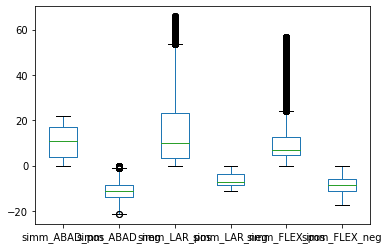

In [154]:
simm.boxplot()

## Check minmax rom for fig.1
46R z is 48 from here vs 34 in fig, everything else is the same

In [18]:
animal_sides = all_data['animal'].unique()
rom_ranges = {}
for animal_side in animal_sides:
    df= all_data[all_data['animal'] == animal_side]
    x_max, x_min = df['Rx'].max(), df['Rx'].min()
    y_max, y_min = df['Ry'].max(), df['Ry'].min()
    z_max, z_min = df['Rz'].max(), df['Rz'].min()
    rom_ranges[animal_side] = {'x':abs(x_max-x_min), 'y':abs(y_max-y_min), 'z':abs(z_max-z_min), }
rom_ranges

{'44L': {'x': 93.17126, 'y': 66.58101, 'z': 54.35738},
 '46L': {'x': 58.24396, 'y': 53.74605, 'z': 54.07597},
 '46R': {'x': 43.80171333, 'y': 62.528580000000005, 'z': 34.243358},
 '48L': {'x': 55.4314, 'y': 41.158991, 'z': 37.513304},
 '48R': {'x': 52.651108, 'y': 54.83135, 'z': 33.4504794}}

## Plot per-trial per-axis moment arms vs time

In [ ]:
def plot2Dcomparison(df, joint, trials):
    absMaxMMA = abs(df.drop(['frame','animal','run','Rx','Ry','Rz','cRx','eRx','eRy','eRz','ceRx'],axis=1).filter(like=joint)).max().max()*1.25
    maxFrame = df['frame'].max()
    df = df[df['trial'].isin(trials)]
    fig = plt.figure(figsize=[12,8])
    axes = []
    for num in range(len(trials)):
        axes.insert(num, fig.add_subplot(int('32'+str(num+1))))
        dfX = df[df['trial']==trials[num]]
        simm_xs = dfX.filter(regex=r'(simm.*ABAD)')
        simm_ys = dfX.filter(regex=r'(simm.*LAR)')
        simm_zs = dfX.filter(regex=r'(simm.*FLEX)')
        maya_xs = dfX.filter(regex=r'(maya.*ABAD)')
        maya_ys = dfX.filter(regex=r'(maya.*LAR)')
        maya_zs = dfX.filter(regex=r'(maya.*FLEX)')
        axes[num].title.set_text(trials[num])
        axes[num].plot(dfX.frame,maya_xs, lw=0.75, c='#FF0000', linestyle='solid', label='ABAD experimental estimate')
        axes[num].plot(dfX.frame,simm_xs, lw=1, c='#FF0000', linestyle='dotted', label='ABAD model prediction')
        if joint != 'clavscap':
            axes[num].plot(dfX.frame,maya_ys, lw=0.75, c='#00CC00', linestyle='solid', label='LAR experimental estimate')
            axes[num].plot(dfX.frame,simm_ys, lw=1, c='#00CC00', linestyle='dotted', label='LAR model prediction')
            axes[num].plot(dfX.frame,maya_zs, lw=0.75, c='#0000FF', linestyle='solid', label='FE experimental estimate')
            axes[num].plot(dfX.frame,simm_zs, lw=1, c='#0000FF', linestyle='dotted', label='FE model prediction')
        axes[num].axhline(c='#060606', lw=0.5)
        axes[num].set_xlim(0, maxFrame)
        axes[num].set_ylim(-absMaxMMA, absMaxMMA)
    plot_title = list(set([" ".join(col.split('.')[1:3]) for col in df.columns if len(col.split('.')) > 3]))[0]
    fig.suptitle(plot_title, fontsize=16)
    plt.subplots_adjust(hspace=0.5, wspace=0.25)
    plt.legend(fontsize='small',bbox_to_anchor=(2, 0.5),loc='center right', ncol=1)
    
muscle_dict = makeMuscleDict(muscles_to_compare, joints)
for muscle in muscle_dict:
    for joint in muscle_dict[muscle]:
        muscle_dict[muscle][joint]['trial'] = muscle_dict[muscle][joint]['animal'] + ['_run']+muscle_dict[muscle][joint]['run'].astype(str)
        trials = sorted(muscle_dict[muscle][joint]['trial'].unique())
        plot2Dcomparison(muscle_dict[muscle][joint],joint, trials)


## Plot 2D diffs

In [ ]:
def plot2Ddiff(df, joint, trials):
    absMaxMMA = abs(df.drop(['frame','animal','run','Rx','Ry','Rz','cRx','eRx','eRy','eRz','ceRx'],axis=1).filter(like=joint)).max().max()*1.25
    maxFrame = df['frame'].max()
    df = df[df['trial'].isin(trials)]
    fig = plt.figure(figsize=[12,8])
    axes = []
    for num in range(len(trials)):
        axes.insert(num, fig.add_subplot(int('32'+str(num+1))))
        dfX = df[df['trial']==trials[num]]
        simm_xs = dfX.filter(regex=r'(simm.*ABAD)')
        simm_ys = dfX.filter(regex=r'(simm.*LAR)')
        simm_zs = dfX.filter(regex=r'(simm.*FLEX)')
        maya_xs = dfX.filter(regex=r'(maya.*ABAD)')
        maya_ys = dfX.filter(regex=r'(maya.*LAR)')
        maya_zs = dfX.filter(regex=r'(maya.*FLEX)')
        diff_xs = simm_xs.values - maya_xs.values
        diff_ys = simm_ys.values - maya_ys.values
        diff_zs = simm_zs.values - maya_zs.values
        axes[num].title.set_text(trials[num])
        axes[num].plot(dfX.frame,diff_xs, lw=0.75, c='#FF0000', linestyle='solid', label='ABAD model - experimental')
        if joint != 'clavscap':
            axes[num].plot(dfX.frame,diff_ys, lw=0.75, c='#00CC00', linestyle='solid', label='LAR model - experimental')
            axes[num].plot(dfX.frame,diff_zs, lw=1, c='#0000FF', linestyle='dotted', label='FE model - experimental')
        axes[num].axhline(c='#060606', lw=0.5)
        axes[num].set_xlim(0, maxFrame)
        axes[num].set_ylim(-absMaxMMA, absMaxMMA)
    plot_title = list(set([" ".join(col.split('.')[1:3]) for col in df.columns if len(col.split('.')) > 3]))[0]
    fig.suptitle(plot_title, fontsize=16)
    plt.subplots_adjust(hspace=0.5, wspace=0.25)
    plt.legend(fontsize='small',bbox_to_anchor=(2, 0.5),loc='center right', ncol=1)


muscle_dict = makeMuscleDict(muscles_to_compare, joints)
for muscle in muscle_dict:
    for joint in muscle_dict[muscle]:
        muscle_dict[muscle][joint]['trial'] = muscle_dict[muscle][joint]['animal'] + ['_run']+muscle_dict[muscle][joint]['run'].astype(str)
        trials = sorted(muscle_dict[muscle][joint]['trial'].unique())
        plot2Ddiff(muscle_dict[muscle][joint],joint, trials)

